F:\Mrig Analytics\mrigAnalytics\mrigutilities.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df.iloc[i]['date'] = datetime.datetime.combine(stock_df.iloc[i]['date'], datetime.time())


date
2020-11-17    240.20
2020-11-18    252.00
2020-11-19    239.75
2020-11-20    242.75
2020-11-23    238.70
               ...  
2024-11-07    859.60
2024-11-08    843.15
2024-11-11    847.65
2024-11-12    826.70
2024-11-13    808.65
Name: close, Length: 979, dtype: float64


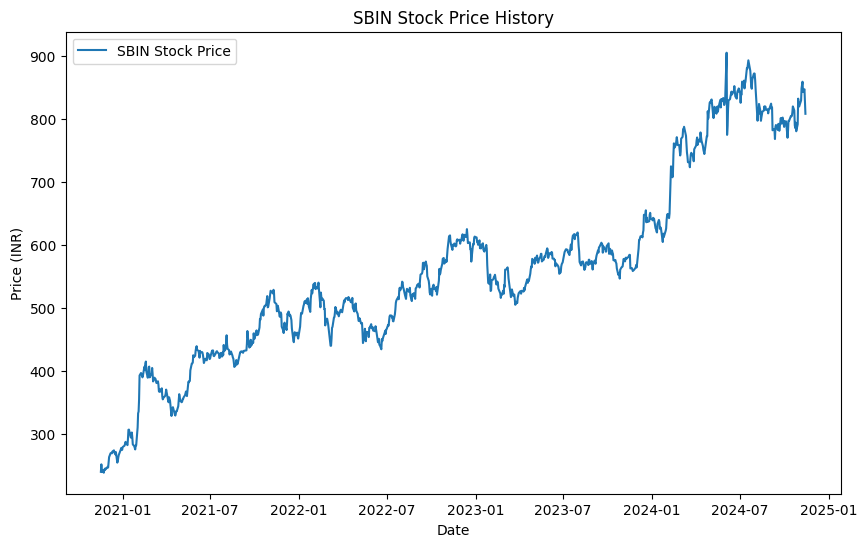

Epoch 1/50
12/12 [==============================] - 5s 109ms/step - loss: 0.0345 - val_loss: 0.0442
Epoch 2/50
12/12 [==============================] - 0s 37ms/step - loss: 0.0070 - val_loss: 0.0097
Epoch 3/50
12/12 [==============================] - 0s 33ms/step - loss: 0.0040 - val_loss: 0.0319
Epoch 4/50
12/12 [==============================] - 0s 30ms/step - loss: 0.0037 - val_loss: 0.0113
Epoch 5/50
12/12 [==============================] - 0s 28ms/step - loss: 0.0029 - val_loss: 0.0119
Epoch 6/50
12/12 [==============================] - 0s 33ms/step - loss: 0.0026 - val_loss: 0.0075
Epoch 7/50
12/12 [==============================] - 0s 30ms/step - loss: 0.0024 - val_loss: 0.0066
Epoch 8/50
12/12 [==============================] - 0s 35ms/step - loss: 0.0024 - val_loss: 0.0053
Epoch 9/50
12/12 [==============================] - 0s 33ms/step - loss: 0.0024 - val_loss: 0.0041
Epoch 10/50
12/12 [==============================] - 0s 34ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 11

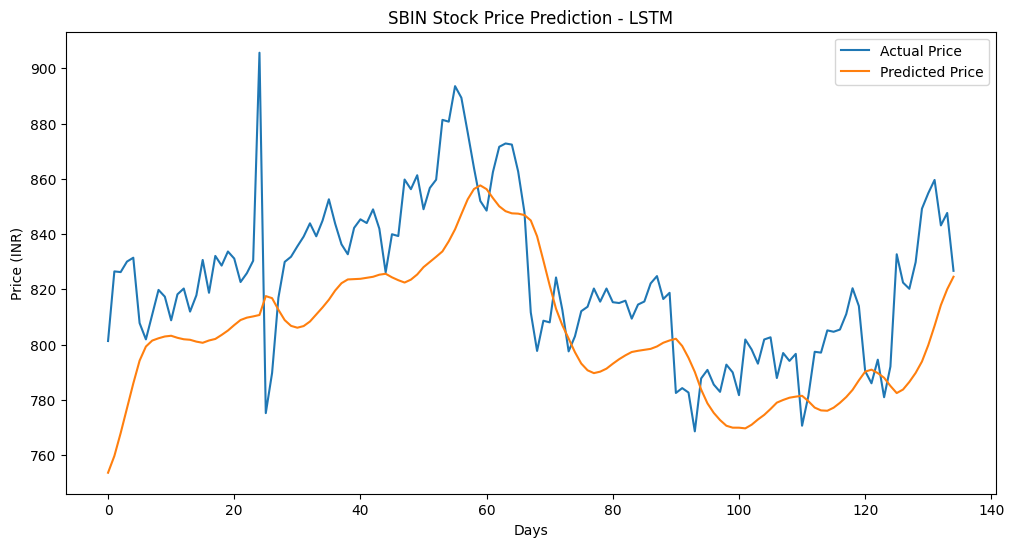

Root Mean Squared Error: 27.57 INR
1/1 [==============================] - 0s 29ms/step


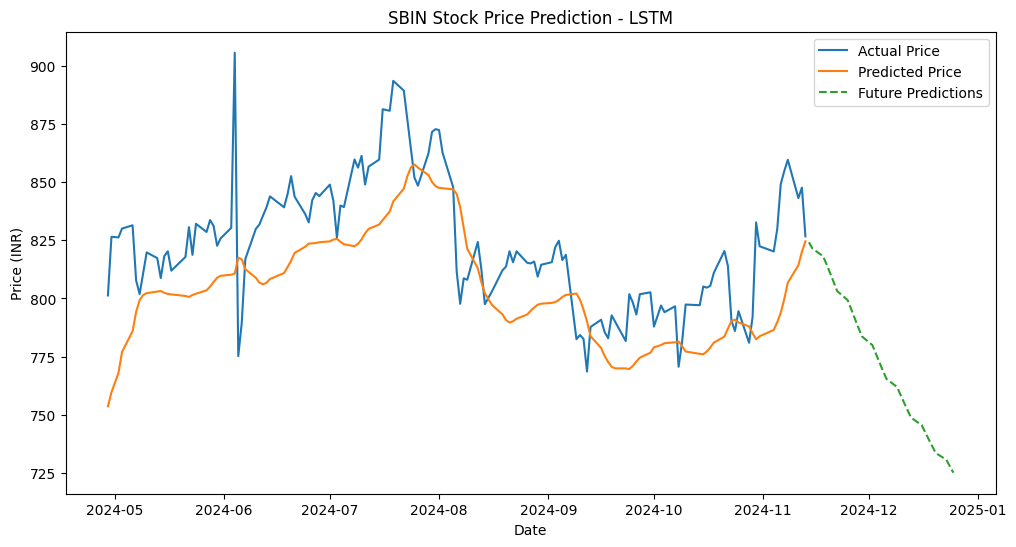

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import datetime
import mrigutilities as mu

stock = "SBIN"

today = datetime.date.today() - datetime.timedelta(days=0)
start = today - datetime.timedelta(days=365*4)

# Fetch historical stock data (TCS)
# data = yf.download(stock, start=start, end=today)['Close']
data = mu.getStockData(stock,start_date=start)['close']
print(data)

# Plot the stock price history
plt.figure(figsize=(10, 6))
plt.plot(data, label=stock+" Stock Price")
plt.title(stock+" Stock Price History")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.show()

# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(data).reshape(-1, 1))

# Define training and testing sets
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

# Function to create dataset with look-back window
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# Check if the data is long enough for the chosen time_step
time_step = 60
if len(train_data) <= time_step or len(test_data) <= time_step:
    raise ValueError(f"Dataset is too short for the selected time_step of {time_step} days.")

# Create train and test datasets
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Predict on test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Reverse scaling

# Invert scaling for y_test to compare predictions with actual prices
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the predicted vs actual prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price")
plt.plot(predictions, label="Predicted Price")
plt.title(stock+" Stock Price Prediction - LSTM")
plt.xlabel("Days")
plt.ylabel("Price (INR)")
plt.legend()
plt.show()

# Calculate RMSE for model evaluation
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions))
print(f"Root Mean Squared Error: {rmse:.2f} INR")



# Number of days to predict into the future
num_days = 30

# Start with the last 60 days of data in the test set
last_60_days = test_data[-time_step:]
future_predictions = []

# Generate predictions iteratively
for _ in range(num_days):
    # Reshape last_60_days to be [samples, time steps, features]
    X_input = last_60_days.reshape((1, time_step, 1))
    
    # Predict the next day's price
    next_pred = model.predict(X_input)
    
    # Store the prediction (in scaled form)
    future_predictions.append(next_pred[0, 0])
    
    # Update last_60_days by removing the oldest price and adding the new prediction
    last_60_days = np.append(last_60_days[1:], next_pred, axis=0)

# Inverse scale the predictions to get actual prices
future_predictions_rescaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Prepare dates for plotting (extend by num_days)
future_dates = pd.date_range(data.index[-1], periods=num_days + 1, freq='B')[1:]

# Plot the actual test data, model predictions on test data, and future predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_rescaled, label="Actual Price")
plt.plot(data.index[-len(predictions):], predictions, label="Predicted Price")
plt.plot(future_dates, future_predictions_rescaled, label="Future Predictions", linestyle="--")
plt.title(stock+" Stock Price Prediction - LSTM")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.show()



date
2020-11-17    240.20
2020-11-18    252.00
2020-11-19    239.75
2020-11-20    242.75
2020-11-23    238.70
               ...  
2024-11-07    859.60
2024-11-08    843.15
2024-11-11    847.65
2024-11-12    826.70
2024-11-13    808.65
Name: close, Length: 979, dtype: float64


F:\Mrig Analytics\mrigAnalytics\mrigutilities.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df.iloc[i]['date'] = datetime.datetime.combine(stock_df.iloc[i]['date'], datetime.time())


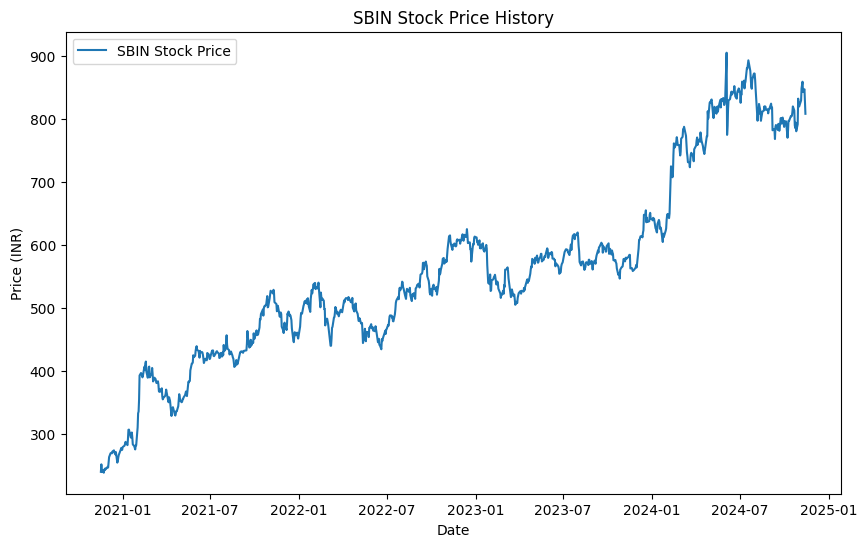

Epoch 1/50
12/12 [==============================] - 4s 92ms/step - loss: 0.0768 - val_loss: 0.0019
Epoch 2/50
12/12 [==============================] - 0s 28ms/step - loss: 0.0085 - val_loss: 0.0718
Epoch 3/50
12/12 [==============================] - 0s 29ms/step - loss: 0.0054 - val_loss: 0.0239
Epoch 4/50
12/12 [==============================] - 0s 28ms/step - loss: 0.0048 - val_loss: 0.0339
Epoch 5/50
12/12 [==============================] - 0s 28ms/step - loss: 0.0038 - val_loss: 0.0233
Epoch 6/50
12/12 [==============================] - 0s 28ms/step - loss: 0.0035 - val_loss: 0.0124
Epoch 7/50
12/12 [==============================] - 0s 28ms/step - loss: 0.0027 - val_loss: 0.0082
Epoch 8/50
12/12 [==============================] - 0s 28ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 9/50
12/12 [==============================] - 0s 28ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 10/50
12/12 [==============================] - 0s 28ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 11/

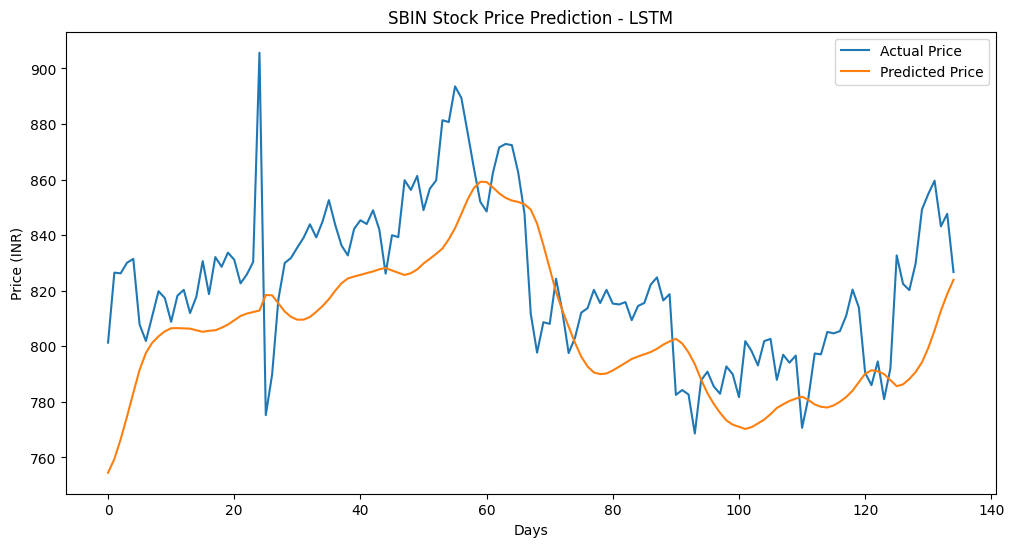

Root Mean Squared Error: 27.00 INR
1/1 [==============================] - 0s 16ms/step


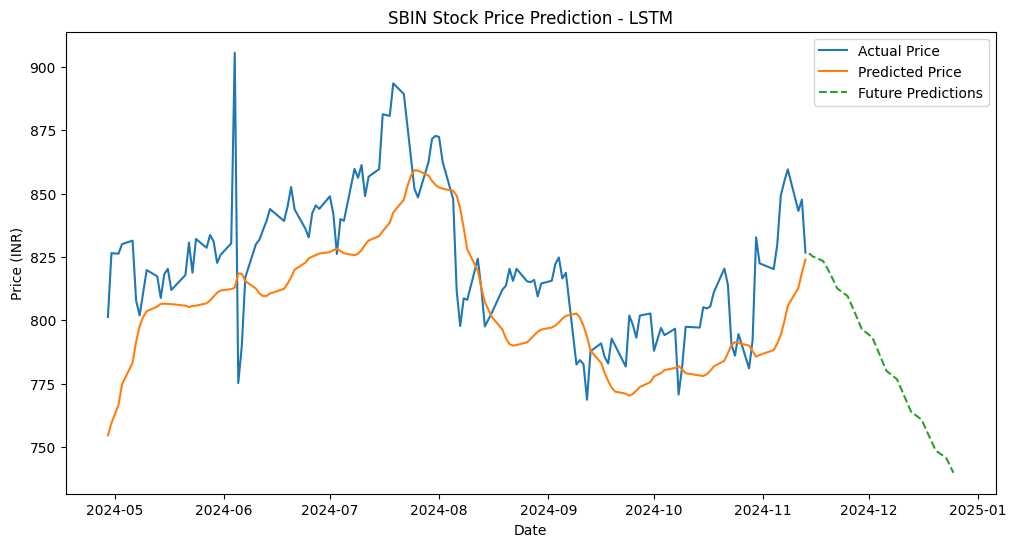

{'actual_price': {'x': DatetimeIndex(['2024-04-29', '2024-04-30', '2024-05-02', '2024-05-03',
                 '2024-05-06', '2024-05-07', '2024-05-08', '2024-05-09',
                 '2024-05-10', '2024-05-13',
                 ...
                 '2024-10-30', '2024-10-31', '2024-11-04', '2024-11-05',
                 '2024-11-06', '2024-11-07', '2024-11-08', '2024-11-11',
                 '2024-11-12', '2024-11-13'],
                dtype='datetime64[ns]', name='date', length=135, freq=None),
  'y': array([[801.3 ],
         [826.5 ],
         [826.25],
         [830.05],
         [831.45],
         [807.8 ],
         [801.9 ],
         [810.8 ],
         [819.8 ],
         [817.35],
         [808.8 ],
         [818.2 ],
         [820.3 ],
         [811.95],
         [817.85],
         [830.65],
         [818.75],
         [832.1 ],
         [828.6 ],
         [833.7 ],
         [831.15],
         [822.65],
         [825.85],
         [830.35],
         [905.65],
         [775.2 ],

In [2]:
import strategies.stock_prediction_LSTM as sp
res = sp.prediction('SBIN',True)
res

In [8]:
type(res['actual_price']['y'])
(res['actual_price']['y']).tolist()

[[801.3],
 [826.5],
 [826.25],
 [830.0499999999998],
 [831.45],
 [807.8],
 [801.8999999999999],
 [810.8],
 [819.8],
 [817.35],
 [808.8],
 [818.2],
 [820.3],
 [811.95],
 [817.85],
 [830.65],
 [818.7500000000001],
 [832.1],
 [828.6],
 [833.7],
 [831.1499999999999],
 [822.65],
 [825.85],
 [830.35],
 [905.65],
 [775.2],
 [789.75],
 [816.95],
 [829.95],
 [831.8],
 [835.55],
 [839.1],
 [843.9],
 [839.2],
 [844.9],
 [852.6],
 [843.7499999999999],
 [836.2999999999998],
 [832.7],
 [842.25],
 [845.35],
 [844.0],
 [848.95],
 [841.95],
 [826.15],
 [839.95],
 [839.3],
 [859.75],
 [856.2499999999999],
 [861.2999999999998],
 [849.0000000000001],
 [856.7],
 [859.7],
 [881.3499999999999],
 [880.7],
 [893.55],
 [889.35],
 [876.8],
 [863.9],
 [851.9999999999999],
 [848.5],
 [862.45],
 [871.6],
 [872.7999999999998],
 [872.4],
 [862.65],
 [847.85],
 [811.65],
 [797.7],
 [808.65],
 [808.0499999999998],
 [824.3],
 [812.6],
 [797.55],
 [802.9999999999999],
 [812.1],
 [813.7],
 [820.3],
 [815.5500000000001],
 